# Statistics - Week 6

* ECDF
* DKW-inequality
* Non-parametric Tests (Kolmogorov-Smirnov, Wilcoxon, Kuskal-Wallis)

## ECDF - Empirical Cumulative Distribution function

An empirical cumulative distribution function (ECDF) $\hat{F}_n(x)$ is a function that maps a variable's observed values to their cumulative probabilities.

$$\hat{F}_n(x) = \frac{\textit{number of observations} \le x}{n} = \frac{1}{n} \sum_{i=1}^n I(x_i \le x)$$

where $I$ is the indicator function, $I(x_i \le x) = 1$ if $x_i \le x$ and $0$ otherwise.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def silly_ecdf(data):

    x = np.unique(data)

    y = []
    for item in x:
        y.append(
            np.sum(data <= item)
        )

    y = np.array(y, dtype=float)
    y /= len(data)

    return x, y

def plot_ecdf(x, y, show=True, legend=True, scatter=True, axs=None):
    if axs is None:
        _, axs = plt.subplots(1, 1)
    if scatter:
        axs.scatter(x, y)
    axs.plot(x, y, '--', label='ECDF')
    if len(x) < 20:
        axs.vlines(x, ymin=0, ymax=y, linestyles='dotted', alpha=0.4)
    axs.set_ylim(0, 1.1)
    axs.set_xlabel('Value')
    axs.set_ylabel('Probability (less than value)')
    if legend:
        axs.legend()
    if show:
        plt.show()


For example, if we have a dataset of $n$ observations, the ECDF of an observation $x$ is equal to the number of observations in our dataset that are less than or equal to $x$, divided by $n$.

![](https://imgs.xkcd.com/comics/convincing.png)

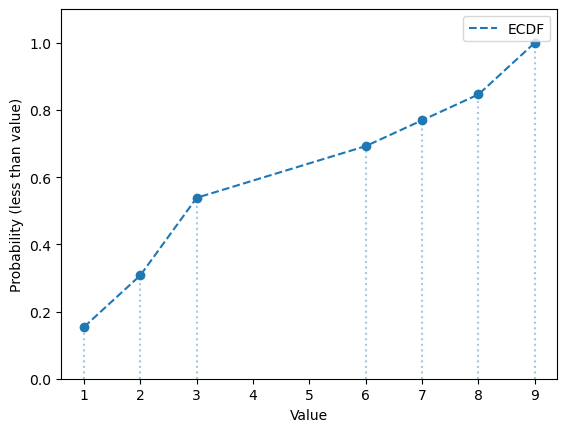

<Figure size 640x480 with 0 Axes>

In [5]:
data = np.array([1, 1, 2, 2, 3, 3, 3, 6, 6, 7, 8, 9, 9])  # n = 13

ecdf_x, ecdf_y = silly_ecdf(data)
plot_ecdf(ecdf_x, ecdf_y)
plt.draw()

Alternative to writing the same functions every time, you could use class `ECDF` from `statsmodels`.
It produces ecdf as a functions, that takes any values and produces the corresponding probabilities.

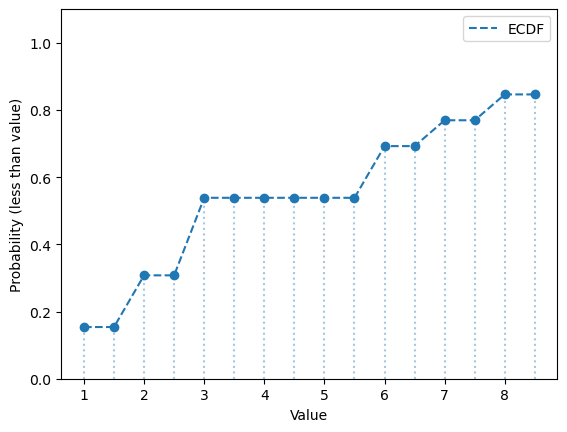

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF as smart_ecdf

ecdf = smart_ecdf(data)

ecdf_x = np.arange(start=data.min(), stop=data.max(), step=0.5)
ecdf_y = ecdf(ecdf_x)

plot_ecdf(ecdf_x, ecdf_y)

The ECDF is a non-parametric method, it gives you an idea on how your sample data is distributed. It can be very useful in comparing two or more datasets, or comparing an observed dataset to a theoretical distribution. It’s also a very simple and visual method to check for outliers, skewness, unimodality, and many other properties.

In [7]:
def silly_hist(data, num_bins=30):
    binw = (data.max() - data.min()) / num_bins

    y = [
        np.sum(
            (data.min() + binw * mult < data) & (data < data.min() + binw * (mult + 1))
        )
        for mult in range(num_bins)
    ]

    y = np.array(y, dtype=float)
    y /= len(data)

    x = [data.min() + binw * mult for mult in range(num_bins)]
    x = np.array(x, dtype=float)

    return x, y


def plot_hist(x, y, show=True):
    binw = x[1] - x[0]
    plt.bar(x, y, label="Hist", edgecolor="black", width=binw)
    plt.xlabel("Value")
    plt.ylabel("Probability")
    plt.legend()
    if show:
        plt.show()

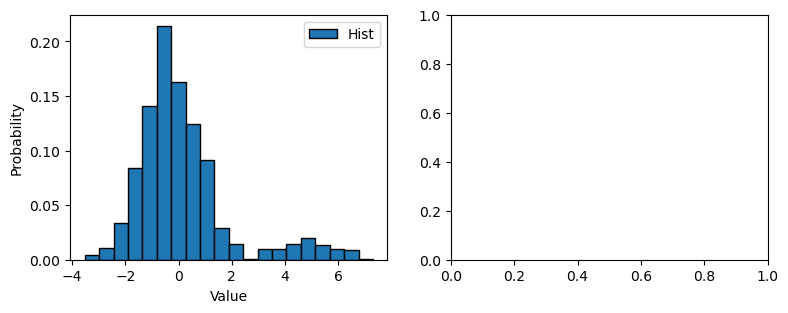

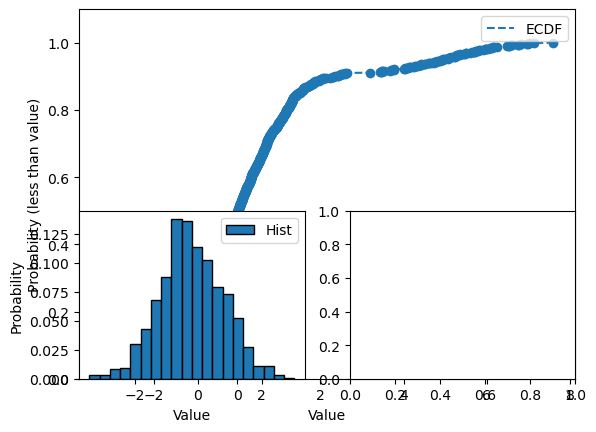

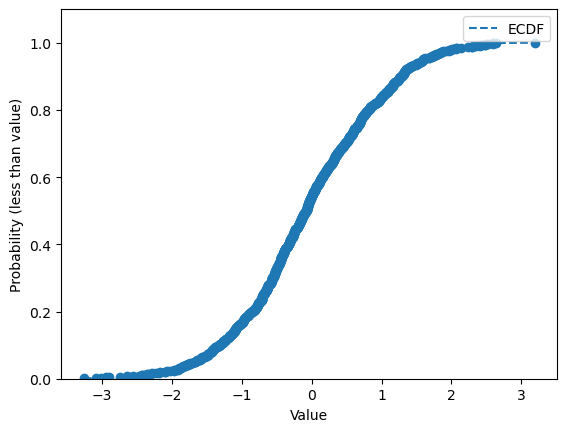

In [8]:
original = np.random.normal(size=1000)
noise = np.random.normal(loc=5, size=100)

data = np.hstack((original, noise))

data_ecdf_x, data_ecdf_y = silly_ecdf(data)
data_hist_x, data_hist_y = silly_hist(data, num_bins=20)

original_ecdf_x, original_ecdf_y = silly_ecdf(original)
original_hist_x, original_hist_y = silly_hist(original, num_bins=20)


plt.figure(figsize=(9, 7))
plt.subplot(221)
plot_hist(data_hist_x, data_hist_y, show=False)
plt.subplot(222)
plot_ecdf(data_ecdf_x, data_ecdf_y, show=False)
plt.subplot(223)
plot_hist(original_hist_x, original_hist_y, show=False)
plt.subplot(224)
plot_ecdf(original_ecdf_x, original_ecdf_y, show=True)

And also, method for histograms:
* matplotlib.pyplot.hist (just to plot and take a look on a histogram)
* numpy.histogram (if you just want to take the result and go)
* scipy.stats.rv_histogram (gives more abilities)

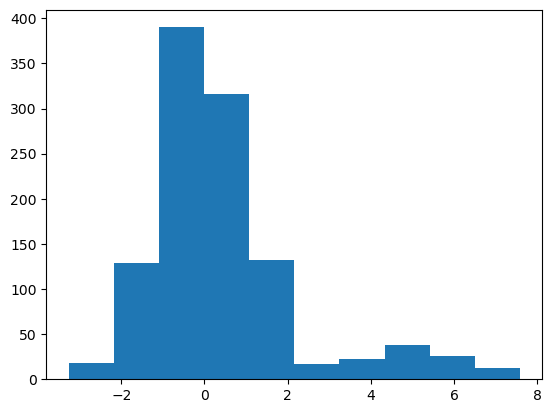

In [9]:
fig, ax = plt.subplots()
_ = ax.hist(data)
plt.show()

In [10]:
hist, bin_edges = np.histogram(data)
hist, bin_edges

(array([ 18, 129, 390, 316, 132,  17,  22,  38,  26,  12]),
 array([-3.25934975, -2.17542662, -1.0915035 , -0.00758038,  1.07634275,
         2.16026587,  3.244189  ,  4.32811212,  5.41203524,  6.49595837,
         7.57988149]))

In [11]:
from scipy.stats import rv_histogram

hist_dist = rv_histogram((hist, bin_edges), density=False)
hist_dist.pdf(1.0)

0.26503053669291465

`rv_histogram` allows you to plot pdf with histogram

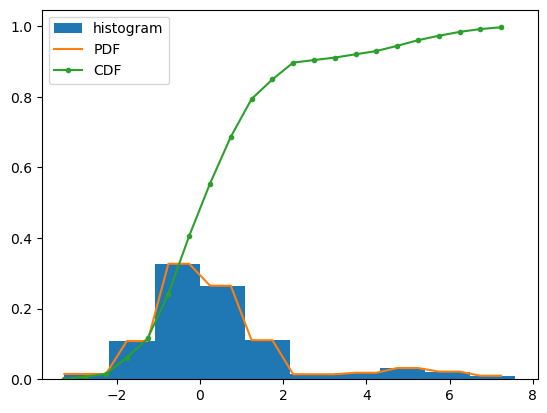

In [12]:
X = np.arange(data.min(), data.max(), 0.5)

fig, ax = plt.subplots()
_ = ax.hist(data, label="histogram", density=True)
_ = ax.plot(X, hist_dist.pdf(X), label="PDF")
_ = ax.plot(X, hist_dist.cdf(X), ".-", label="CDF")
ax.legend()
plt.show()

### Exercise

1. Sample 10, 100, and 1000 samples from exponential distribution. Compute ECDF for each sample. For each sample also plot 0.25, 0.5 and 0.75-quantile. Retrieve the maximum L1 error from the original distribution CDF (between samples and original distribution).

Sample 0 max_error: 0.0817972948415204
Sample 1 max_error: 0.04450035744708769
Sample 2 max_error: 0.03874040195483869


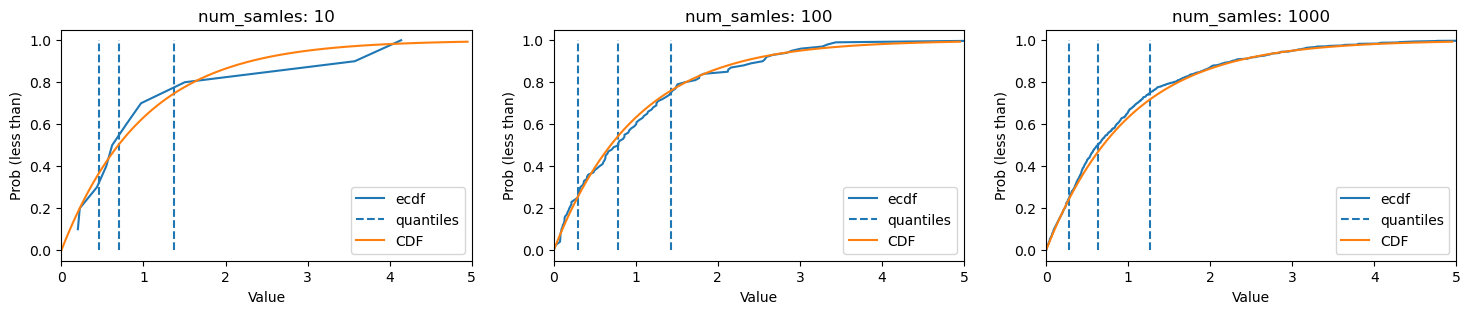

In [13]:
from scipy.stats import expon
from statsmodels.distributions.empirical_distribution import ECDF

samples = []
ecdfs = []
n_series = (10, 100, 1000)
x_min, x_max = 0, 5
x_series = np.arange(x_min, x_max, 0.05)

quantiles = [0.25, 0.5, 0.75]

for n in n_series:
    cur_sample = np.sort(expon.rvs(0, 1, size=n))
    cur_ecdf = ECDF(cur_sample)
    samples.append(cur_sample)
    ecdfs.append(cur_ecdf(cur_sample))

fig, ax = plt.subplots(1, 3, figsize=(18,3))
for i in range(len(n_series)):
    sample, ecdf = samples[i], ecdfs[i]
    cur_quant = [np.quantile(sample, q) for q in quantiles]
    
    err = np.abs(ecdf - expon.cdf(sample))
    print(f"Sample {i} max_error: {err.max()}")
    
    ax[i].plot(sample, ecdf, label="ecdf")
    ax[i].set_xlim((x_min, x_max))
    ax[i].vlines(cur_quant, 0, 1, linestyle='--', label="quantiles")
    ax[i].plot(x_series, expon.cdf(x_series), label="CDF")
    ax[i].set_title(f"num_samles: {n_series[i]}")
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Prob (less than)")
    ax[i].legend()

plt.show()

 ## Dvoretzky–Kiefer–Wolfowitz inequality

* **AKA** DKW inequality
* **AKA** Massart inequality

DKW inequality gives a bound on the difference between ECDF of a sample and CDF of the underlying population. This non-parametric statistics is used to assess the quality of a sample and to establish the existence and consistency of estimators.


Again, DKW inequality bounds the probability that the random function $\hat{F}_n(x)$ differs from $F(x)$ by more than a given constant $\epsilon \gt 0$ anywhere on the real line.

One-sided estimate:

$$\Pr {\Bigl (}\sup _{{x\in {\mathbb  R}}}{\bigl (}F_{n}(x)-F(x){\bigr )}>\varepsilon {\Bigr )}\leq e^{{-2n\varepsilon ^{2}}}\qquad {\text{for every }}\varepsilon \geq {\sqrt  {{\tfrac  {1}{2n}}\ln 2}},\quad (e^{{-2n \varepsilon ^2}} \geq \frac{1}{2})$$

It implies a two-sided estimate:

$$\Pr {\Bigl (}\sup _{{x\in {\mathbb  R}}}|F_{n}(x)-F(x)|>\varepsilon {\Bigr )}\leq 2e^{{-2n\varepsilon ^{2}}}\qquad {\text{for every }}\varepsilon >0$$

In [14]:
def dkw(n, epsilon, population, full_ecdf=True):
    assert epsilon > 0
    mul = 1

    sample = np.random.choice(population, n)
    ecdf_x, ecdf_y = silly_ecdf(sample)

    pr = mul * np.power(np.e, -2 * n * epsilon**2)

    bottom_y = ecdf_y - epsilon
    bottom_x = ecdf_x[(bottom_y >= 0) & (bottom_y <= 1)]
    bottom_y = bottom_y[(bottom_y >= 0) & (bottom_y <= 1)]

    data = [
        [
            (ecdf_x, ecdf_y, ".--"),
            {
                "color": "b",
                "label": "ecdf",
            },
        ],
        [
            (bottom_x, bottom_y, "--"),
            {
                "color": "g",
                "alpha": 0.3,
                "label": "ecdf - epsilon",
            },
        ],
    ]

    top_y = ecdf_y + epsilon
    top_x = ecdf_x[(top_y >= 0) & (top_y <= 1)]
    top_y = top_y[(top_y >= 0) & (top_y <= 1)]

    data.append(
        [
            (top_x, top_y, "--"),
            {
                "color": "g",
                "alpha": 0.3,
                "label": "ecdf + epsilon",
            },
        ]
    )

    if full_ecdf:
        cdf_x, cdf_y = silly_ecdf(population)
        data.append(
            [
                (cdf_x, cdf_y),
                {
                    "color": "orange",
                    "alpha": 0.8,
                    "label": "cdf (precise)",
                },
            ]
        )

    return data, pr


def plot_dkw(data, pr):
    plt.figure(figsize=(5, 5))
    plt.title(f"Pr = {pr:.10f}")
    for args, kwargs in data:
        plt.plot(*args, **kwargs)
    plt.xlabel("Value")
    plt.ylabel("Probability (less than value)")
    plt.legend()
    plt.show()

The inequality shows that for any given $\epsilon$, as the sample size $n$ increases, the probability that the difference between the ECDF and the CDF is less than $\epsilon$ becomes arbitrarily close to $1$.

This means that as the sample size gets larger and larger, the ECDF of a sample becomes an increasingly accurate estimator of the underlying population's CDF.

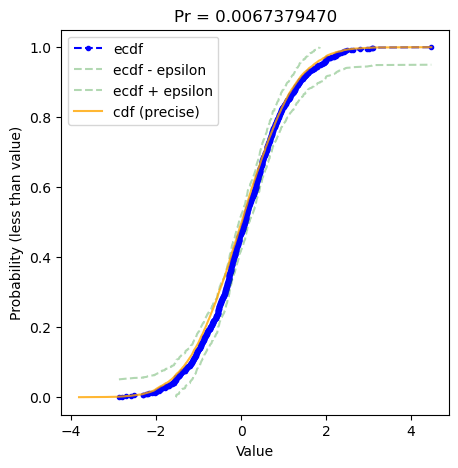

In [15]:
population = np.random.normal(size=10000)
epsilon = 0.05
n = 1000

dkw_data, prob = dkw(n, epsilon, population)
plot_dkw(dkw_data, prob)

The DKW inequality is also used to derive other results such as the Glivenko–Cantelli theorem, which states that the maximum difference between the ECDF and the CDF converges to 0 with probability 1.

It's also important to note that this inequality does not impose any assumptions about the underlying distribution, that is it holds for any distribution. This makes it a useful tool in non-parametric statistics, as it does not require knowledge of the underlying distribution's parameters.

### Exercise

2. Plot 2d-histogram of probability bounds for $n$ and $\epsilon$ ranges specified in the code cell. Draw a conclusion about decision boundary for $n$ and $\epsilon$.

In [16]:
n_min = 1
n_max = 1000
n_size = 1000

eps_min = 0.01
eps_max = 0.2
eps_size = 1000

(1000, 1000)


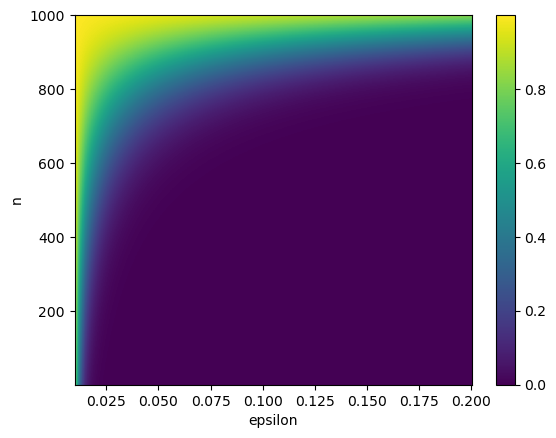

In [17]:
def raw_dkw(n, epsilon):
    return np.power(np.e, -2 * n.T * epsilon**2)

n_series = np.linspace(n_min, n_max, n_size)
eps_series = np.linspace(eps_min, eps_max, eps_size)

n_mesh, eps_mesh = np.meshgrid(n_series, eps_series)
print(n_mesh.shape)
dkw_mesh = raw_dkw(n_mesh.T, eps_mesh)

# ax.pcolormesh(x, y, z, vmin=z.min(), vmax=z.max())
plt.pcolormesh(eps_series, n_series[::-1], dkw_mesh, vmin=dkw_mesh.min(), vmax = dkw_mesh.max())
plt.xlabel("epsilon")
plt.ylabel("n")
plt.colorbar()

The plot above shows that for large $n$ and $\varepsilon$ the $F_n(x)$ and $F(x)$ are alomost the similar. If $n$ goes to infinity $F_n(x)$ would become a CDF. If $\varepsilon$ is large $F_n(x)$ can have greater uncertainty with respect to real CDF. 

---
> Table description

Some of the advantages of nonparametric tests include:

* They do not require assumptions about the underlying distribution of the data
* They are less sensitive to outliers and skewed distributions
* They are generally more robust and less affected by violations of assumptions

While nonparametric tests have many advantages, there are also some potential disadvantages to consider:

* Lower Power: Nonparametric tests tend to have lower statistical power than parametric tests, meaning that they may be less likely to detect a difference when one actually exists. This can be a concern when sample sizes are small or the difference between the groups is small.
* Less informative results: Nonparametric tests are often less informative than parametric tests. For example, while a parametric t-test will give you a p-value and a point estimate of the mean difference, a nonparametric test such as the Wilcoxon rank-sum test will only give you a p-value.
* Limited application: Nonparametric tests are designed for specific types of data, such as ordinal, continuous, discrete or categorical data. Their application is limited and may not be suitable for all types of data.
* Less interpretability: The results of nonparametric tests can be more difficult to interpret and explain than those of parametric tests. For example, a p-value from a nonparametric test does not have the same meaning as a p-value from a parametric test.

---

What is the problem with p-values here?

For instance, hemoglobin levels are sampled from 10 vegetarians to assess the prevalence of anemia:

In [18]:
hg_sample = [12.3,  13.1, 11.3, 10.1, 14.0, 13.3, 10.5, 12.3, 10.9, 11.9]

And we want to check the following two hypotheses:

$H_0:$ the median is equal to 13

$H_1:$ the median is less than 13

If $H_0$ is true, how many observations in the sample would you expect to have a hemoglobin level below 13?

In our sample we have 7 values below 13. Let's have a look at the histogram:

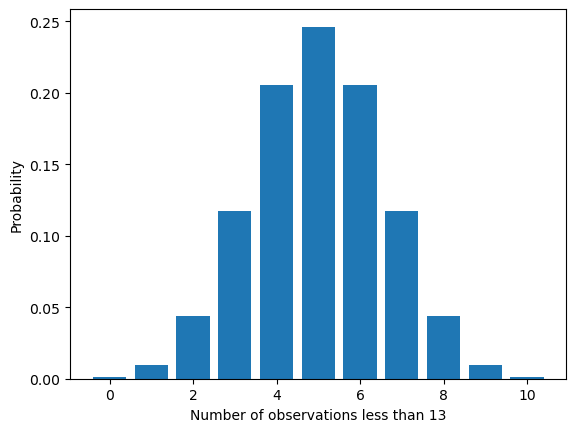

In [19]:
from scipy.stats import binom

n = 10 #we have 10 observations in our sample
p = 0.5 #probability of being below median is 0.5

r_values = list(range(n+1))
dist = [binom.pmf(r, n, p) for r in r_values ]  #we have a binomial distribution

plt.bar(r_values, dist)
plt.xlabel("Number of observations less than 13")
plt.ylabel("Probability")
plt.show()

The probability of getting 7 or more observations less than 13 is $1-\sum_{i=1}^{6}b(i; 10, 0.5) = 1 - 0.828 = 0.172$, therefore, we are unable to reject $H_0$.

In summary, nonparametric tests have lower power and can provide less information than parametric tests. They also have limited applicability, and the results can be less interpretable. However, in situations where assumptions of parametric tests are not met, they provide a valid alternative that can still make valid statistical conclusions.

## Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test is used to decide if a sample comes from a population with a specific distribution. In essence, the test answers the question:
* "What is the probability that this collection of samples could have been drawn from that probability distribution?"

or, in the second case,

* "What is the probability that these two sets of samples were drawn from the same (but unknown) probability distribution?"

### Assumptions



*   The scale of measurement is at least ordinal
*   The test is only exact for continuous variables
*   The sample size is large. For small sample sizes, the test may not have enough power to detect a difference between the sample's ECDF and the specified CDF

### Hypotheses

- $H_0:$	The data follow a specified distribution
- $H_1:$	The data do not follow the specified distribution

### Base algorithm

#### One sample case

* Calculate ECDF from the sample
* Calculate KS Statistic: $D_{n}=\sup _{x}|\hat{F}_{n}(x)-F(x)|$
    *  Intuitively, the statistic takes the largest absolute difference between the two distribution functions across all $x$ values
* Use [Table](https://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/) to see the critical value and compare the obtained $D_{n}$ with it

#### Two-sample case

* Calculate $\hat{F}_{1,n}$ and $\hat{F}_{2,m}$
* Calculate Ks statistic: $D_{n,m}=\sup _{x}|F_{1,n}(x)-F_{2,m}(x)|$
* For large samples, the null hypothesis is rejected at level $\alpha$  if:
    * $D_{n,m}>{\sqrt {-\ln \left({\tfrac {\alpha }{2}}\right)\cdot {\tfrac {1+{\tfrac {m}{n}}}{2m}}}}$


### Example - rainfalls

Determine whether the data represented in the following frequency table is normally distributed where $x$ represents rainfall amounts.

| x    | 100 | 200 | 300 | 400 | 500 | 600 | 700 | 800 | 900 | 1000 |
| ---- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---- |
| Freq | 8   | 25  | 88  | 172 | 243 | 252 | 144 | 49  | 13  | 6    |

Given $E[X] = 481.4$ and $\sigma[X] = 155.2$

In [20]:
x = [100 * i for i in range(1, 11)]
freq = [8, 25, 88, 172, 243, 252, 144, 49, 13, 6]

ecdf_orig = [sum(freq[i::-1]) / sum(freq) for i in range(len(freq))]
ecdf_orig

[0.008, 0.033, 0.121, 0.293, 0.536, 0.788, 0.932, 0.981, 0.994, 1.0]

In [21]:
x_mean = 481.4
x_std = 155.2

z_scores = (np.array(x) - x_mean) / x_std
z_scores

array([-2.45747423, -1.81314433, -1.16881443, -0.52448454,  0.11984536,
        0.76417526,  1.40850515,  2.05283505,  2.69716495,  3.34149485])

In [22]:
from scipy.stats.distributions import norm

normal_ecdf = norm.cdf(z_scores)
normal_ecdf

array([0.00699589, 0.03490478, 0.1212392 , 0.29997079, 0.54769718,
       0.7776186 , 0.92050923, 0.97995571, 0.99650337, 0.99958336])

In [23]:
difference = np.abs(ecdf_orig - normal_ecdf)
difference

array([0.00100411, 0.00190478, 0.0002392 , 0.00697079, 0.01169718,
       0.0103814 , 0.01149077, 0.00104429, 0.00250337, 0.00041664])

In [24]:
D_n = difference.max()
D_n

0.011697175935242332

From the Kolmogorov-Smirnov Table we see that

$D_{n,\alpha} = D_{1000,0.05} = \frac{1.36}{\sqrt{1000}} = 0.043007$

Since $D_{n} = 0.011697 \lt 0.043007 = D_{n,\alpha}$, we conclude that the data is a good fit for the normal distribution.

We also could use `scipy.stats` implementation:

In [25]:
from scipy.stats import kstest
n_x = norm.rvs(size=100, random_state=42)
kstest(n_x, norm.cdf)

KstestResult(statistic=0.10357070563896065, pvalue=0.2180555337851624, statistic_location=0.37569801834567196, statistic_sign=1)

### Exercise

3. You want to relocate from Russia to another country of your choice. Check whether your favorite product will cost as same as in Russia. (Perform ks test, obviously.)

> [Data description](https://www.kaggle.com/datasets/mvieira101/global-cost-of-living?select=cost-of-living_v2.csv)


In [26]:
import pandas as pd

cost_of_living = pd.read_csv("cost-of-living_v2.csv")

cost_of_living

,city,country,x1,x2,x3,x4,x5,x6,x7,x8,...,x47,x48,x49,x50,x51,x52,x53,x54,x55,data_quality
0,Seoul,South Korea,7.68,53.78,6.15,3.07,4.99,3.93,1.48,0.79,...,110.36,742.54,557.52,2669.12,1731.08,22067.70,10971.90,2689.62,3.47,1
1,Shanghai,China,5.69,39.86,5.69,1.14,4.27,3.98,0.53,0.33,...,123.51,1091.93,569.88,2952.70,1561.59,17746.11,9416.35,1419.87,5.03,1
2,Guangzhou,China,4.13,28.47,4.98,0.85,1.71,3.54,0.44,0.33,...,43.89,533.28,317.45,1242.24,688.05,12892.82,5427.45,1211.68,5.19,1
3,Mumbai,India,3.68,18.42,3.68,2.46,4.30,2.48,0.48,0.19,...,41.17,522.40,294.05,1411.12,699.80,6092.45,2777.51,640.81,7.96,1
4,Delhi,India,4.91,22.11,4.30,1.84,3.68,1.77,0.49,0.19,...,36.50,229.84,135.31,601.02,329.15,2506.73,1036.74,586.46,8.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4951,Peterborough,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4952,Georgetown,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4953,Ixtapa Zihuatanejo,Mexico,5.16,30.94,12.89,0.98,NaN,1.80,0.62,0.41,...,103.14,412.55,257.84,515.69,412.55,NaN,NaN,NaN,NaN,0
4954,Iqaluit,Canada,29.65,74.27,13.71,6.67,8.89,3.71,3.52,4.08,...,NaN,NaN,NaN,2964.60,2964.60,NaN,NaN,NaN,6.53,0


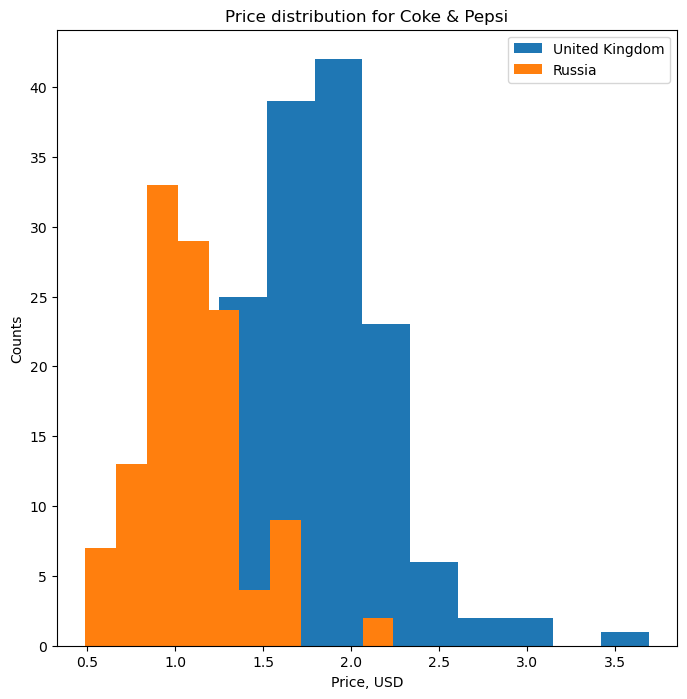

In [27]:
# Solution 3

#Use 0.05 level of significance, select any product
# col == cost_of_living
country1 = "Russia"
country2 = "United Kingdom"

product = "Coke & Pepsi"

country1_pepsi = cost_of_living[cost_of_living["country"] == country1]["x7"].dropna().to_numpy()
country2_pepsi = cost_of_living[cost_of_living["country"] == country2]["x7"].dropna().to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(country2_pepsi, label=country2)
ax.hist(country1_pepsi, label=country1)
ax.set_title(f"Price distribution for {product}")
ax.set_ylabel("Counts")
ax.set_xlabel("Price, USD")
ax.legend()
plt.show()

In [28]:
kstest(country1_pepsi, country2_pepsi)

KstestResult(statistic=0.7614649165451305, pvalue=4.954304287134958e-39, statistic_location=1.34, statistic_sign=1)

 So, the probatility that these two samples are drawn from the same distribution is extremely small, and therefore the hypothesis that their distribution are the same is rejected. The distance and statistics sign suggest that Coke & Pepsi in United Kingdom is on average more expensive by 1.34$ USD than in Russia.

:(


## Mann-Whitney U test


The Mann-Whitney U test can be used to test whether there is a difference between two independent samples.

It is non-parametric counterpart to the t-test for two independent samples. The difference is that Mann-Whitney U test does not require the data be normally distributed.

#### Assumtions

* All observations of both groups are independent of each other
    * *Read* - *the data is not paired*
* The variable do not have to satisfy a distribution curve
    * *Read* - *do not bother yourself with distribution assumption*

#### Hypotheses

* $H_0$: The distributions of both populations are identical
* $H_1$: The distributions of both populations are not identical

#### Base algorithm

* Put two samples together and rank the observations
    * The rank of the smallest observation is one, the rank of the next smallest is two, and so on.
    * Remember to resolve ties: take average of ranks for the same $|D|$ values
* Calculate rank sums:
    * Sum rank $R_1$ of sample 1 of size $n_1$
    * Sum rank $R_2$ of sample 2 of size $n_2$
* Calculate $U$ statistic for both samples:
    * $U_1 = n_1 * n_2+\frac{(n_1+1)*n_1}{2}-R_1$
    * $U_2 = n_1 * n_2+\frac{(n_2+1)*n_2}{2}-R_2$
* Retrieve test statistics $U = min(U_1, U_2)$
* Determine whether the $U$ supports or rejects the hypotheses (reject $H_0$ if $U<=U_\alpha$)
    * In case of $n_1 n_2 <= 20$ use [Mann-Whitney U table table](https://ocw.umb.edu/psychology/psych-270/other-materials/RelativeResourceManager.pdf)
    * In case of $n_1 n_2 > 20$ we use normal approximation - convert to z-value:
        * calculate $E[U] = \frac{n_1 n_2}{2}$
        * calculate $Var[U] = \sqrt \frac{n_1 n_2 (n_1+n_2+1)}{12} = \sigma^2[U]$
            * If there are a large number of ties, a better estimate of the variance is given by: $Var[U] = \sqrt {\frac{n_1 n_2}{(n_1+n_2)(n_1+n_2+1)}(\frac{(n_1+n_2)^3-(n_1+n_2)}{12}-\sum_{i=1}^g\frac{t_j^3-t_j}{12})}$, where $i$ varies over the set of tied ranks and $t_i$ is the number of times (i.e. frequency) that the rank $t$ appears.
        * calculate z_value: $Z = \frac{U - E[U]}{\sigma[U]}$

#### Example - effectiveness of a treatment

Consider a Phase II clinical trial designed to investigate the effectiveness of a new drug to reduce symptoms of asthma in children. A total of $n=10$ participants are randomized to receive either the new drug or a placebo. Participants are asked to record the number of episodes of shortness of breath over a 1 week period following receipt of the assigned treatment. The data are
shown below:

In [29]:
treatment_data = [('placebo', 7), ('placebo', 5), ('placebo', 6), ('placebo', 4), ('placebo', 12),
                  ('new_drug', 3), ('new_drug', 6), ('new_drug', 4), ('new_drug', 2), ('new_drug', 1)]

$H_0:$ The two drugs have equal effect

$H_1:$ The two drugs have not equal effect

In [30]:
treatment_df = pd.DataFrame(treatment_data, columns=['treatment', 'n_episodes'])
treatment_df["rank"] = treatment_df["n_episodes"].rank()

R_placebo = treatment_df.loc[treatment_df['treatment']=='placebo',['rank']].sum().values[0]
R_new_drug = treatment_df.loc[treatment_df['treatment']=='new_drug',['rank']].sum().values[0]

n_placebo = len(treatment_df.loc[treatment_df['treatment']=='placebo'])
n_new_drug = len(treatment_df.loc[treatment_df['treatment']=='new_drug'])
U_placebo = n_placebo*n_new_drug + (n_placebo+1)*n_placebo/2 - R_placebo
U_new_drug = n_placebo*n_new_drug + (n_new_drug+1)*n_new_drug/2 - R_new_drug

U = min(U_placebo, U_new_drug)
U

3.0

In [31]:
treatment_df

,treatment,n_episodes,rank
0,placebo,7,9.0
1,placebo,5,6.0
2,placebo,6,7.5
3,placebo,4,4.5
4,placebo,12,10.0
5,new_drug,3,3.0
6,new_drug,6,7.5
7,new_drug,4,4.5
8,new_drug,2,2.0
9,new_drug,1,1.0


Critical value for $\alpha = 0.05$ from the table is $U_\alpha = 2$.

Since $U> U_\alpha$ we fail to reject $H_0$ and conclude that the two drugs have equal effect

#### Exercise

4. For the following data showing the age at diagnosis of type II diabetes in young adults, test the following hypotheses using normal approximation:

    $H_0:$ The age at diagnosis is the same for males and females

    $H_1:$ The age at diagnosis is different for males and females

In [33]:
diabete_diagnosis_data = [('male', 19), ('male', 22), ('male', 16), ('male', 29), ('male', 24),
                          ('female', 20), ('female', 11), ('female', 17), ('female', 12)]

In [36]:
#Solution 4

#I propose you the following algorithm

#U_test - test statistic
#n_m - number of males in our sample
#n_f - number of females in our sample
diagnosis_df = pd.DataFrame(diabete_diagnosis_data, columns=['sex', 'age'])
diagnosis_df["rank"] = diagnosis_df["age"].rank()

R_male = diagnosis_df.loc[diagnosis_df['sex']=='male',['rank']].sum().values[0]
R_female = diagnosis_df.loc[diagnosis_df['sex']=='female',['rank']].sum().values[0]

n_male = len(diagnosis_df.loc[diagnosis_df['sex']=='male'])
n_female = len(diagnosis_df.loc[diagnosis_df['sex']=='female'])
U_male = n_male*n_female + (n_male+1)*n_male/2 - R_male
U_female = n_male*n_female + (n_female+1)*n_female/2 - R_female

U_test = min(U_male, U_female)

z = (U_test - n_male*n_female/2)/(np.sqrt((n_male*n_female*(n_male+n_female+1))/12))
z

-1.7146428199482247

The one-tailed p-value for this z is $0.044$, therefore, for the two-tailed test the p-value for the found $z$ is approximately $0.09$

$0.09>0.05$, that is why we cannot reject the null hypothesis.

Using the scipy library we got the results that also support non-rejection of the null hypothesis.

In [38]:
from scipy.stats import mannwhitneyu

U1, p = mannwhitneyu(diagnosis_df.loc[diagnosis_df['sex']=='male', ['age']],
                     diagnosis_df.loc[diagnosis_df['sex']=='female', ['age']], method="exact")
p[0]

0.1111111111111111

## Wilcoxon signed-rank test

The Wilcoxon-Test can be used to test whether there is a difference between two dependent samples.

It is non-parametric counterpart to the t-test. The difference is that Wilcoxon-test does not require the data be normally distributed.

For dependent sample, the measured values are in pairs. The pairs result, for example, from repeated measurements on the same individuals.

#### Assumtions

* Only two dependent random samples with at least ordinally scaled characteristics need to be available
    * *Read* - *data should be paired and comparable*
* The variable do not have to satisfy a distribution curve
    * *Read* - *do not bother yourself with distribution assumption*

#### Hypotheses

* $H_0$: In the population, the median difference of the two dependent samples is equal
* $H_1$: In the population, the median difference is positive *(one-sided)*
* $H_1$: In the population, the median difference is negative *(one-sided)*
* $H_1$: In the population, the central tendencies of the two dependent samples are unequal *(two-sided)*

#### Base algorithm

* Calculate the **differences** between paired observations - $D_i\textit{, where } i = 1, 2, ..., n$
* Retrieve **rank** from **absolute** differences - $R_i\textit{, where } i = 1, 2, ..., n$
    * The rank of the smallest observation is one, the rank of the next smallest is two, and so on.
    * Remember to resolve ties: take average of ranks for the same $|D|$ values
* Calculate rank sums:
    * Sum ranks of positive diffs - $T^{+}=\sum_{1\leq i\leq n,\ D_{i}>0}R_{i}$
    * Sum ranks of negative diffs - $T^{-}=\sum_{1\leq i\leq n,\ D_{i}<0}R_{i}$
* Retrieve test statistics $W_1 = min(T^{+}, T^{-})$
* Determine whether the W_1 supports or rejects the hypotheses
    * In case of $n <= 25$ use [Wilcoxon signed ranks table](https://www.real-statistics.com/statistics-tables/wilcoxon-signed-ranks-table/)
    * In case of $n > 25$ we use normal approximation - convert to z-value:
        * calculate $E[W] = \frac{n(n+1)}{4}$
        * calculate $Var[W] = \frac{n(n+1)(2n+1)}{24} = \sigma^2[W]$
            * If there are a large number of ties, a better estimate of the variance is given by: $Var[W] = \frac{n(n+1)(2n+1)}{24} - \frac{\sum{t^{3}_i} - \sum{t_i}}{48}$, where $i$ varies over the set of tied ranks and $t_i$ is the number of times (i.e. frequency) that the rank $t$ appears.
        * calculate z_value: $Z = \frac{W - E[W]}{\sigma[W]}$

#### Example - student Happiness

Suppose, we have 10 students, with collected happiness score before and after the mid exam:

In [39]:
import pandas as pd

data = np.array(
    [
        [0, 100, 80],
        [1, 85, 75],
        [2, 70, 90],
        [3, 40, 50],
        [4, 65, 40],
        [5, 80, 20],
        [6, 50, 50],
        [7, 51, 40],
        [8, 99, 92],
        [9, 42, 73],
    ]
)
scores = pd.DataFrame(
    data, columns=["Student", "Happiness before midterm", "Happiness after midterm"]
)
scores

,Student,Happiness before midterm,Happiness after midterm
0,0,100,80
1,1,85,75
2,2,70,90
3,3,40,50
4,4,65,40
5,5,80,20
6,6,50,50
7,7,51,40
8,8,99,92
9,9,42,73


Null $H_0:$ The central tendency is equal

Alternative $H_1:$ The central tendency is ~goes brr~ changed negativelly (one-sided case) $\alpha=0.05$

> If the null hypothesis is true, we expect to see similar numbers of lower and higher ranks that are both positive and negative (i.e., $T^+$ and $T^-$ would be similar).

> If the alternative hypothesis is true we expect to see more lower and begative ranks (in this example, more students with happiness scores decrease after exam as compared to before, i.e., $T^-$ much larger than $T^+$).

In [40]:
# Calculate differences and retrieve signs

scores["|Diff|"] = abs(
    scores["Happiness after midterm"] - scores["Happiness before midterm"]
)
scores = scores.drop(scores[scores["|Diff|"] == 0].index)

scores["Sign"] = (
    scores["Happiness after midterm"] - scores["Happiness before midterm"]
) / scores["|Diff|"]

scores["Rank"] = scores["|Diff|"].rank()
scores

,Student,Happiness before midterm,Happiness after midterm,|Diff|,Sign,Rank
0,0,100,80,20,-1.0,5.5
1,1,85,75,10,-1.0,2.5
2,2,70,90,20,1.0,5.5
3,3,40,50,10,1.0,2.5
4,4,65,40,25,-1.0,7.0
5,5,80,20,60,-1.0,9.0
7,7,51,40,11,-1.0,4.0
8,8,99,92,7,-1.0,1.0
9,9,42,73,31,1.0,8.0


In [41]:
T_negative = scores[scores["Sign"] < 0]["Rank"].sum()
T_positive = scores[scores["Sign"] > 0]["Rank"].sum()

W = min(T_negative, T_positive)

print(f"T-: {T_negative}, T+: {T_positive}, W: {W}")

T-: 29.0, T+: 16.0, W: 16.0


Given, $n = 9$ (bc we ommited difference with zero), $\alpha=0.05$, *one-sided* $H_1$ and $W = 16$.
Critical calue from [the table](https://www.real-statistics.com/statistics-tables/wilcoxon-signed-ranks-table/) $W_{cr.} = 8$

Since $W = 16 > 8 = W_{cr.}$, we reject the null hypothesis, and so conclude there is significant difference between the two timestamps (before and after the midterm).

#### Exercise

5. Let's take worldwide happiness score (the data can be found [here](https://www.kaggle.com/datasets/unsdsn/world-happiness)), collected in 2015 and 2019, and test the following hypotheses:

$H_0:$ The central tendency is equal

$H_1:$ The central tendency is not equal (two-sided case) $\alpha=0.05$

Use a normal approximation of $W$.

In [42]:
chosen_columns = ["Country", "Happiness Score", "Freedom"]

wh_2015 = pd.read_csv("2015.csv")[
    ["Country", "Happiness Score", "Freedom"]
]

rename_map = {
    "Country or region": "Country",
    "Score": "Happiness Score",
    "Freedom to make life choices": "Freedom",
}

wh_2019 = pd.read_csv("2019.csv")[
    ["Country or region", "Score", "Freedom to make life choices"]
].rename(columns=rename_map)

wh_2015_2019 = wh_2015.merge(wh_2019, on=["Country"], suffixes=("_2015", "_2019"))
wh_2015_2019

,Country,Happiness Score_2015,Freedom_2015,Happiness Score_2019,Freedom_2019
0,Switzerland,7.587,0.66557,7.480,0.572
1,Iceland,7.561,0.62877,7.494,0.591
2,Denmark,7.527,0.64938,7.600,0.592
3,Norway,7.522,0.66973,7.554,0.603
4,Canada,7.427,0.63297,7.278,0.584
...,...,...,...,...,...
144,Rwanda,3.465,0.59201,3.334,0.555
145,Benin,3.340,0.48450,4.883,0.349
146,Syria,3.006,0.15684,3.462,0.013
147,Burundi,2.905,0.11850,3.775,0.220


In [52]:
# metric = "Happiness Score"
metric = "Freedom"
wh_2015_2019["|Diff|"] = abs(
    wh_2015_2019[f"{metric}_2019"] - wh_2015_2019[f"{metric}_2015"]
)
wh_2015_2019["Sign"] = (
    wh_2015_2019[f"{metric}_2019"] - wh_2015_2019[f"{metric}_2015"]
) / wh_2015_2019["|Diff|"]

wh_2015_2019["Rank"] = wh_2015_2019["|Diff|"].rank()
wh_2015_2019

,Country,Happiness Score_2015,Freedom_2015,Happiness Score_2019,Freedom_2019,|Diff|,Sign,Rank
0,Switzerland,7.587,0.66557,7.480,0.572,0.09357,-1.0,105.0
1,Iceland,7.561,0.62877,7.494,0.591,0.03777,-1.0,37.0
2,Denmark,7.527,0.64938,7.600,0.592,0.05738,-1.0,65.0
3,Norway,7.522,0.66973,7.554,0.603,0.06673,-1.0,74.0
4,Canada,7.427,0.63297,7.278,0.584,0.04897,-1.0,57.0
...,...,...,...,...,...,...,...,...
144,Rwanda,3.465,0.59201,3.334,0.555,0.03701,-1.0,35.0
145,Benin,3.340,0.48450,4.883,0.349,0.13550,-1.0,131.0
146,Syria,3.006,0.15684,3.462,0.013,0.14384,-1.0,133.0
147,Burundi,2.905,0.11850,3.775,0.220,0.10150,1.0,113.0


In [54]:
T_negative = wh_2015_2019[wh_2015_2019["Sign"] < 0]["Rank"].sum()
T_positive = wh_2015_2019[wh_2015_2019["Sign"] > 0]["Rank"].sum()

W = min(T_negative, T_positive)
print(f"T-: {T_negative}, T+: {T_positive}, W: {W}")

T-: 8204.5, T+: 2970.5, W: 2970.5


In [56]:
#Solution 5
n = len(wh_2015_2019)
expected_w = n * (n+1) / 4
variance_w = n*(n+1)*(2*n + 1) / 24

print('Mean = {} and variance={}'.format(expected_w, variance_w))

Mean = 5587.5 and variance=278443.75


In [57]:
#Solution 5

Z = (W - expected_w) / np.sqrt(variance_w)
Z

-4.959466780309037

Z-value of $-4.9594$ gives us yields a p-value that is $\le .00001$.
So we reject a null hypothesis. Thus, The central tendency of worldwide happiness score in 2015 and 2019 is not equal.

In [58]:
from scipy.stats import wilcoxon

res = wilcoxon(
    wh_2015_2019[f"{metric}_2015"], wh_2015_2019[f"{metric}_2019"], method="approx"
)
res


WilcoxonResult(statistic=2970.5, pvalue=7.068652878069503e-07)

It is important to note that the Wilcoxon test assumes that the differences between the two sets of measurements are symmetric around zero and that the magnitude of the differences does not depend on the magnitude of the measurements. Additionally, it requires the data to be ordinal or continuous.

## Kuskal-Wallis test - one-way ANOVA on ranks

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal.It is a non-parametric version of ANOVA.

The test works on 2 or more independent samples, which may have different sizes.

> Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

### Hypotheses

$H_0:$ population medians are equal.

$H_1:$ population medians are not equal.

### Assumptions for the Kruskal Wallis Test

* One independent variable with two or more levels (independent groups). The test is more commonly used when you have three or more levels. For two levels, consider using the Mann Whitney U Test instead.
* Ordinal scale, Ratio Scale or Interval scale dependent variables.
* Your observations should be independent. In other words, there should be no relationship between the members in each group or between groups.
* All groups should have the same shape distributions.

### Base algorithm

* Rank all data from all groups together; i.e., rank the data from 1 to N ignoring group membership.
    * Remeber to deal with ties
* Calculate the H statistic:
$$ H = (N-1)\frac{\sum_{i=1}^{g} n_{i} (\bar{r}_{i\cdot} - \bar{r})^2}{\sum_{i=1}^g\sum_{j=1}^{n_i}(r_{ij} - \bar{r})^2}, $$

where
    * $N$ is the total number of observations across all groups
    * $g$ is the number of groups
    * $n_{i}$ is the number of observations in group $i$
    * $\bar{r}_{i \cdot}$ is the average rank of all observations in group $i$
    * $\bar{r} =\frac 12 (N+1)$ is the average of all the $r_{ij}$
    * $r_{ij}$ is the rank (among all observations) of observation $j$ from group $i$

$$\bar{r}_{i \cdot} = \frac{\sum_{j=1}^{n_i} r_{ij} }{n_i}$$


Forget about previous step and just do a shortcut:

1) Calculate average rank for each group

$$\bar{r}_{i\cdot} = \frac{\sum_{j=1}^{n_i}{r_{ij}}}{n_i}$$

2) Calculate
    
$$H={\frac {12}{N(N+1)}}\sum _{i=1}^{g}n_{i}{\bar {r}}_{i\cdot }^{2}-\ 3(N+1)$$


3) Make correction for ties. Divide H from previous point by $1 - \frac{\sum_{i=1}^G (t_i^3 - t_i)}{N^3-N}$, where $G$ is the number of groupings of different tied ranks, and $t_i$ is the number of tied values within group $i$ that are tied at a particular value.

This correction usually makes little difference in the value of $H$ unless there are a large number of ties.

4) Finally, the decision to reject or not the null hypothesis is made by comparing $H$ to a critical value $H_{c}$ obtained from a table or a software for a given significance or alpha level. If $H$ is bigger than $H_{c}$, the null hypothesis is rejected. The distribution of $H$ can be approximated by a chi-squared distribution with $g-1$ degrees of freedom.



### Example - students anxiety

You want to find out how test anxiety affects actual test scores. The independent variable “test anxiety” has three levels: `no anxiety`, `low-medium anxiety` and `high anxiety`. The dependent variable is the exam score, rated from 0 to 100%.

| Group              | 0  | 1  | 2  | 3  | 4  |
| ------------------ | -- | -- | -- | -- | -- |
| no anxiety         | 23 | 41 | 54 | 66 | 78 |
| low-medium anxiety | 45 | 55 | 60 | 70 | 72 |
| high anxiety       | 20 | 30 | 34 | 40 | 44 |

Assign ranks to all values independently

| Group              | 0  | 1  | 2  | 3  | 4  | rank0  | rank1  | rank2  | rank3  | rank4  | rank sum |
| ------------------ | -- | -- | -- | -- | -- | ------ | ------ | ------ | ------ | ------ | -------- |
| no anxiety         | 23 | 41 | 54 | 66 | 78 | 2      | 6      | 9      | 12     | 15     | 44       |
| low-medium anxiety | 45 | 55 | 60 | 70 | 72 | 8      | 10     | 11     | 13     | 14     | 56       |
| high anxiety       | 20 | 30 | 34 | 40 | 44 | 1      | 3      | 4      | 5      | 7      | 20       |

Calculate H statistic
$$
H = \frac{12}{15(15 + 1)}(\frac{44^2}{5} + \frac{56^2}{5} + \frac{20^2}{5}) - 3(15 + 1) =
$$

In [63]:
12 / (15 * (15 + 1)) * ((44**2) / 5 + (56**2) / 5 + (20**2) / 5) - 3 * (15 + 1)

6.720000000000006

For $3 – 1 = 2$ degrees of freedom and an alpha level of $0.05$, the critical $𝝌^2$ value is $5.9915$.

In this case, $5.9915$ is less than $6.72$, so we can reject the null hypothesis.

### Example - worldwide happiness

Let's use the data from the previous happiness as an example for scipy based Kuskal-Wallis test.

In [64]:
wh_2019

,Country,Happiness Score,Freedom
0,Finland,7.769,0.596
1,Denmark,7.600,0.592
2,Norway,7.554,0.603
3,Iceland,7.494,0.591
4,Netherlands,7.488,0.557
...,...,...,...
151,Rwanda,3.334,0.555
152,Tanzania,3.231,0.417
153,Afghanistan,3.203,0.000
154,Central African Republic,3.083,0.225


In [65]:
min_happiness = wh_2019["Happiness Score"].min()
max_happiness = wh_2019["Happiness Score"].max()

min_happiness, max_happiness

(2.853, 7.769)

In [66]:
middle_score = min_happiness + (max_happiness - min_happiness) / 2

group_1 = wh_2019[wh_2019["Happiness Score"] < middle_score]["Freedom"]
group_2 = wh_2019[wh_2019["Happiness Score"] >= middle_score]["Freedom"]
len(group_1), len(group_2)

(75, 81)

In [67]:
from scipy.stats import kruskal

kruskal(group_1, group_2)

KruskalResult(statistic=28.726730860185658, pvalue=8.334533793526938e-08)

### Exercise

Vladimir has tested the performance of two different search engines and recorded their scores. Using the Kruskal-Wallis test:



1.   Formulate the hypothesis you able to test;
2.   Test these hypotheses and draw the conclusion on the work of two different search engines.

You can see the data below

In [68]:
search_df = pd.read_csv('search.csv')
search_df

,simple_search,super_duper_bert_search
0,0.697898,0.772413
1,0.686611,0.739866
2,0.249121,0.790170
3,0.400000,0.560799
4,0.613381,0.056897
...,...,...
220,0.543007,0.275589
221,0.536454,0.771297
222,0.562810,0.454294
223,0.476189,0.608744


(array([56.,  8., 17.,  8., 16., 36., 19., 34., 19., 12.]),
 array([0.        , 0.0790545 , 0.158109  , 0.2371635 , 0.31621799,
        0.39527249, 0.47432699, 0.55338149, 0.63243599, 0.71149049,
        0.79054498]),
 <BarContainer object of 10 artists>)

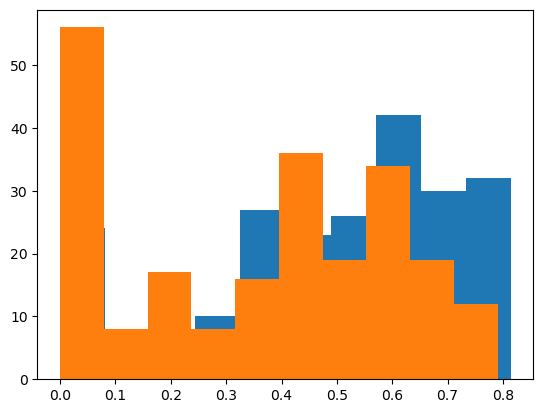

In [69]:
plt.hist(search_df["super_duper_bert_search"])
plt.hist(search_df["simple_search"])

Your hypotheses:
    H0: median performance of so called `super_duper_bert_search` is similar from median of simple search.
    H1: median performance of `super_duper_bert_search` is different from median of simple search. 

In [70]:
kruskal(search_df["super_duper_bert_search"], search_df["simple_search"])

KruskalResult(statistic=33.901805525878935, pvalue=5.796488279841811e-09)

*Conclusion:* the test has shown that the H0 hypothesis is wrong, therefore the median performance of super duper mega puper bert-powered search is different than that of simple search.

## References

* [ECDF and Histogram](https://lazymodellingcrew.com/post/post_14_reading_like_a_fourthgrader_ta/)
* [Glivenko-Cantelli proof](https://home.uchicago.edu/~amshaikh/webfiles/glivenko-cantelli.pdf)
* [Kolmogorov-Smirnov test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm)
* [City temperature data](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities)